# Circus Oz Analysis

This is an exploratory data analysis of collected data from Circus Oz. The main focus will be around gender, roles and temporal relationships.

The data consists of...
- event records with attached dates
- person records for each event
- each person record contains data on gender and role type

### Import packages and pre-process data

In [1]:
# for data mgmt
import pandas as pd
import numpy as np
from collections import Counter
import re

# for plotting
import matplotlib.pyplot as plt

# for network graphs
import networkx as nx
from pyvis import network as net
from IPython.display import IFrame

# for statistical processes
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import pareto

import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('data/23 Nov_Circus Oz_MasterList-RoleCategories_1978-2009_Clean.xlsx')

# remove redundant rows
df = df[~df['PERSON.NUMBER'].isnull()]

# assign event number to each related person
for idx,row in df.iterrows():
    if pd.isnull(row['EVENT.NUMBER']): 
        for col, val in row_dict.items(): df.at[idx, col] = val
    else: 
        row_dict = row.loc["EVENT.NUMBER":"(TBC)_VENUE.TYPE"].to_dict()
        
# create separate events dataset
events_df = df.loc[:,"EVENT.NUMBER":"(TBC)_VENUE.TYPE"]\
              .drop_duplicates()\
              .reset_index(drop=True)

### Event participation by demi-decade

We use a bar chart to highlight the participation rates across time. Participation rate being the number of people involved in an event in a time period. Data has been collected between 1977 to 2022, however we focus only on data between **1977 to 2009** as this period holds the richest records.

Data has been aggregated into five-year bins. The figure shows a steady incline over the first 20 years, peaking in the 1995-1999 period, and gradually declining.

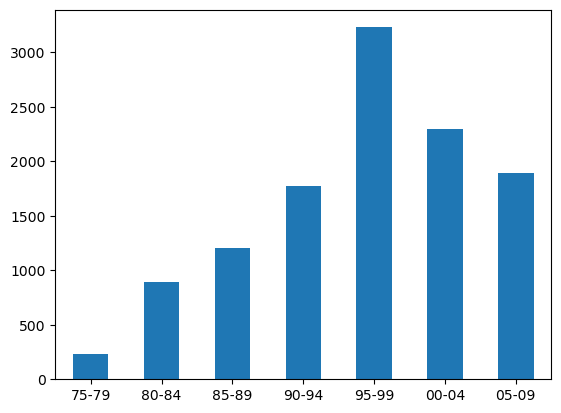

In [2]:
df['Year'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%Y'))
df['Year'] = df['Year'].astype(int)
df['Year_decade'] = [ int(np.floor(int(year)/5) * 5) 
                            for year in np.array(df['Year'])]

df_noinjuries = df[df['Role.Category.Concatinate'] != 'Injured']

ax = df_noinjuries['Year_decade'].value_counts().reset_index().sort_values('index').head(-1)\
.plot(x='index',y='Year_decade', kind='bar', rot=0)

ax.set_xlabel('')
plt.xticks(range(0, 7, 1), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])

# adjust legend
plt.legend().set_visible(False)

### Event participation by year

To get a more granular view of the data, we plot the time as individual years. The highest peak is 1998 with 772 records. We provide the top 5 years with the highest number of participants below.

| Year | Participants |
| :- | -: |
| 1998 | 772 |
| 1995 | 753 |
| 1996 | 726 |
| 1993 | 714 |
| 2001 | 608 |

Interesting to note that there was no data for the year 1981.

In the figure below, we also include injured persons recorded for each event. We see a peak in 1993 of 108. This is quite significant as the median is 6 injuries per year (mean = 15).

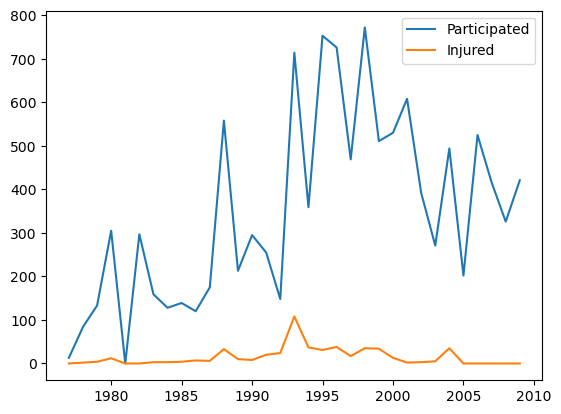

In [3]:
ax = df_noinjuries['Year'].\
    value_counts().\
    reset_index().\
    append({'index':1981,'Year':0}, ignore_index=True).\
    sort_values('index').\
    head(-1).\
    plot(x='index',y='Year', rot=0, label='Participated')

df_injuries = df[df['Role.Category.Concatinate'].str.contains('Injured',na=False)]

pd.merge(df_injuries['Year'].\
    value_counts().\
    reset_index(),
    pd.DataFrame({'index': list(range(1977, 2010))}),
    how='outer').\
    fillna(0).\
    sort_values('index').\
    plot(x='index',y='Year', rot=0, ax=ax, label='Injured')


ax.set_xlabel('')

# adjust legend
plt.legend().set_visible(True)

### Event participation by month

The bar chart shows the participation rate over the entire dataset for each month. The data suggests that events with highest participation rates occur in Autumn. October is the month with the lowest frequency.

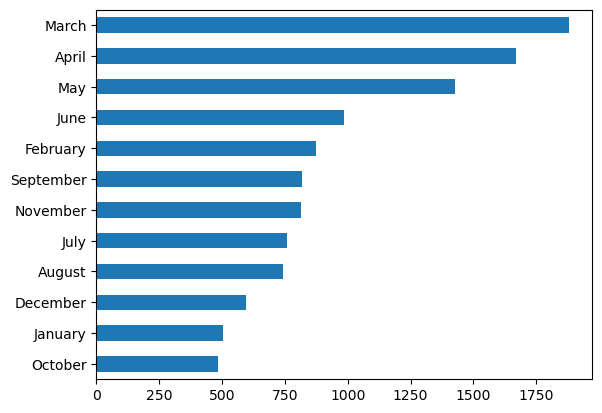

In [4]:
df['Month'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%B'))
df['month_number'] = df['DATE.FROM.(General)'].apply(lambda x: x.strftime('%m'))
ordered_months = df[['Month','month_number']]\
.drop_duplicates()\
.sort_values('month_number')['Month']\
.unique()

df['Month'] = pd.Categorical(df['Month'],categories=ordered_months, ordered=True)

df_noinjuries = df[df['Role.Category.Concatinate'] != 'Injured']

df_noinjuries['Month'].value_counts().sort_values().plot(kind='barh')
plt.show()

### Event participation by month-year

The bar chart shows the top ten months (within their respective year) with the highest participation rates. March 1998 has the highest participation among all month-years (272 participants). For reference the mean participation rate for monthly data is 54 participants.

In March 1998, there were six events all under the title, Circus Oz (Mike and Dan's Show).

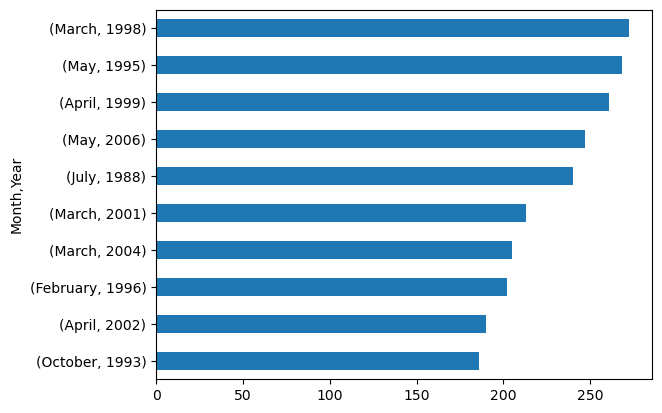

In [5]:
df_noinjuries[['Month','Year']].value_counts().head(10).sort_values().plot(kind='barh')
plt.show()

### Gender summary

We use a series of donut charts to explore how gender has been recorded. The first donut chart highlights the distribution of raw gender records and the second donut chart shows the proportion of only `Female` and `Male` records. There are five different categories according to the raw data. We have provided a frequency table below with the raw counts.

| Gender | Frequency |
| :- | -: |
| M | 4586 |
| F | 4937 |
| U | 32 |
| 0 | 2443 |
| NaN | 12 |

According to the raw data, `Female` occurs the most (40.4%), followed by `Male` (38.6%) and `0` (20.6%).`0` represents unverified records. In AusStage, these `0` records have been entered as `Male`, however `Male` is the default when entering people records into AusStage. For this reason, `Female` and `Male` are only used when they can be verified through a secondary source. 

The third donut chart shows what the proportion would look like if we assumed `0` to be `Male`. The balance between `Male` and `Female` shifts.

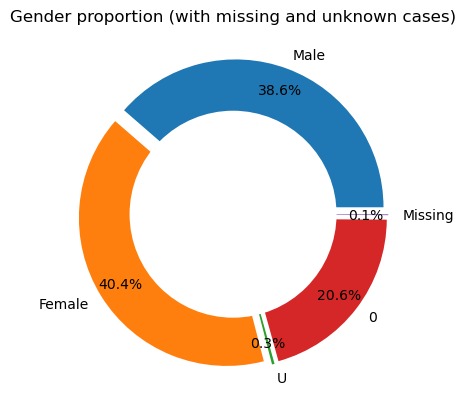

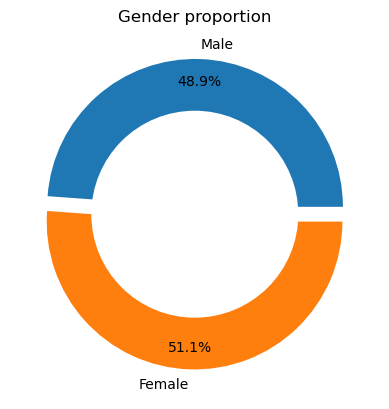

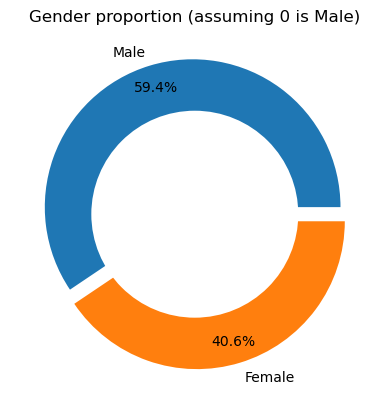

In [6]:
## Gender Proportion
df_gender=pd.DataFrame(dict(Counter(df_noinjuries["Gender"])).items(),
                              columns=["Gender","Frequency"])
# print(df_gender)

# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender['Frequency'], labels=['Male','Female','U',0,'Missing'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion (with missing and unknown cases)')
  
# Displaying Chart
plt.show()

# without null
# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender[df_gender['Gender'].isin(['M','F'])]['Frequency'], 
        labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion')
  
# Displaying Chart
plt.show()


# Pie Chart
plt.pie(df_gender[df_gender['Gender'].isin(['M','F',0])]\
        .replace({0: 'M'})\
        .groupby('Gender')\
        .sum()\
        .reset_index()\
        .sort_values('Gender',ascending=False)['Frequency'], 
        labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion (assuming 0 is Male)')
  
# Displaying Chart
plt.show()

#### Participation by time

The visualisations below show the participation rates across time for `Male`, `Female` and `0`. The clustered bar chart shows that the majority of unverified persons lie within the 95-99 period. Furthermore, `Female` leads partipication across most periods.

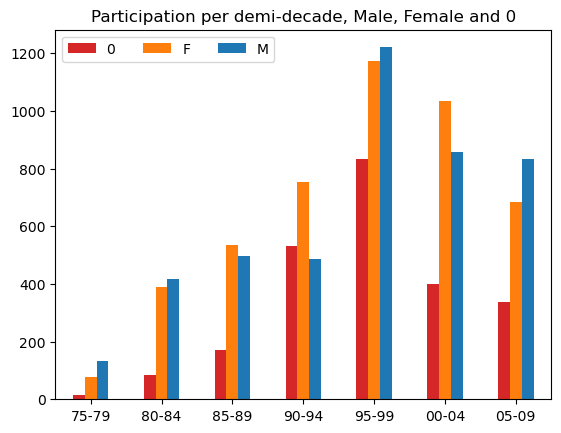

In [7]:
bymf= df_noinjuries[(df_noinjuries['Gender'].isin(['M','F', 0])) & (df_noinjuries.Year_decade < 2010)]
ax = pd.crosstab(bymf['Year_decade'], 
            bymf['Gender'])\
.plot(kind='bar', rot=0, color=['tab:red','tab:orange','tab:blue'])
plt.legend(loc="upper left", ncol=3)
plt.title('Participation per demi-decade, Male, Female and 0', )
ax.set_xlabel('')
plt.xticks(range(0, 7, 1), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

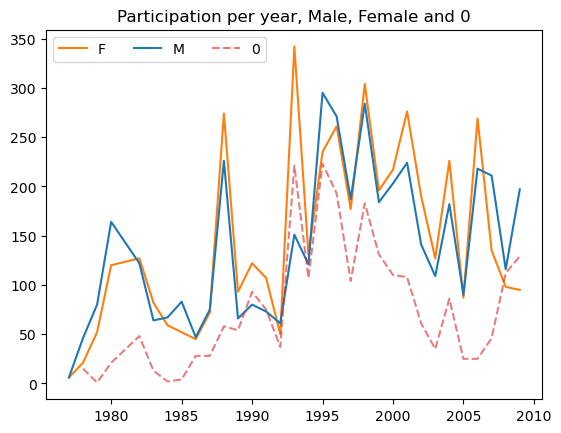

In [8]:
ax = pd.crosstab(bymf[bymf.Gender != 0]['Year'], 
                 bymf[bymf.Gender != 0]['Gender'])\
.plot(rot=0, color=['tab:orange','tab:blue'])

pd.crosstab(bymf[bymf.Gender == 0]['Year'], 
            bymf[bymf.Gender == 0]['Gender'])\
.plot(rot=0, color=['tab:red'], alpha=0.6, linestyle='dashed', ax=ax)

plt.legend(loc="upper left", ncol=3)
plt.title('Participation per year, Male, Female and 0', )
ax.set_xlabel('')
plt.show()

### Person summary

We calculate summary statistics of participation rate across all persons and also across gender. These are shown in the table below.

| Gender | Count | Mean | Standard Deviation | Min | 25% | 50% (Median) | 75% | Max |
| :- | :- | :- | :- | :- | :- | :- | :- | :- |
| All | 721 | 16.0 | 35.3 | 1 | 1 | 2 | 14 | 378 |
| M | 126 | 35.4 | 57.2 | 1 | 4 | 13 | 38.5| 378 |
| F | 123 | 38.0 | 45.3 | 1 | 8 | 20 | 53.5 | 243 |
| 0 | 468 | 5.1 | 12.6 | 1 | 1 | 1 | 3 | 130 |

**Some insights from the above**:
- 721 unique persons (excluding injured).
- Mean number of events per person = 16.
- However, median (2) is a better measure of centrality as the data is right skewed.
- 75% of the data participate in 14 or less events.
<br><br>
- `Male` and `Female` median is a lot larger when we disregard other values in the Gender column.
    - This plays into the idea that people with fewer records have less information about them.
- Compared to `Male` (126) and `Female` (123), 0 occurs far more frequently (468).
- `Female` median (20) is larger than male (13) and 0 (1).
<br><br>
- 75% of `Male` perform in less than 39 events.
- 75% of `Female` perform in less than 54 events.
- 75% of `0` perform in 3 or less events.

We also provide a histogram with a layered boxplot to highlight the skewness seen in participation rates.

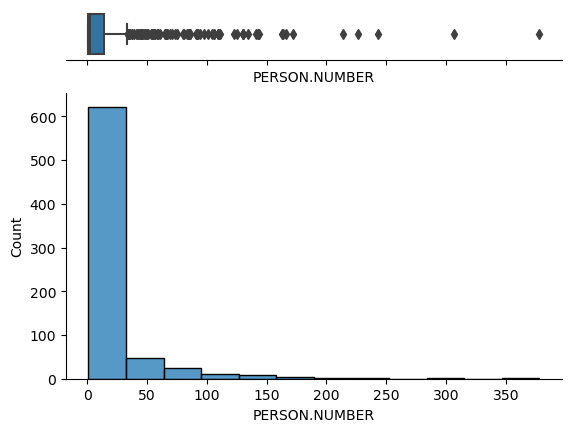

In [9]:
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=df_noinjuries['PERSON.NUMBER'].value_counts(), ax=ax_box)
sns.histplot(x=df_noinjuries['PERSON.NUMBER'].value_counts(), 
             bins=12, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Below we list 20 people who have been involved in the most Circus Oz events. We have coloured each bar according to the gender record.
- Tim Coldwell leads with 378 events followed by Michael Ling with 307 events.
- Both males and females are among the highest
- Only one `0` record, Terry Lycos

One interesting insight from looking at participation rates is that 99% of all events in the data have links to the top 1% of most active participants (from Tim Coldwell to Mel Fyfe). 

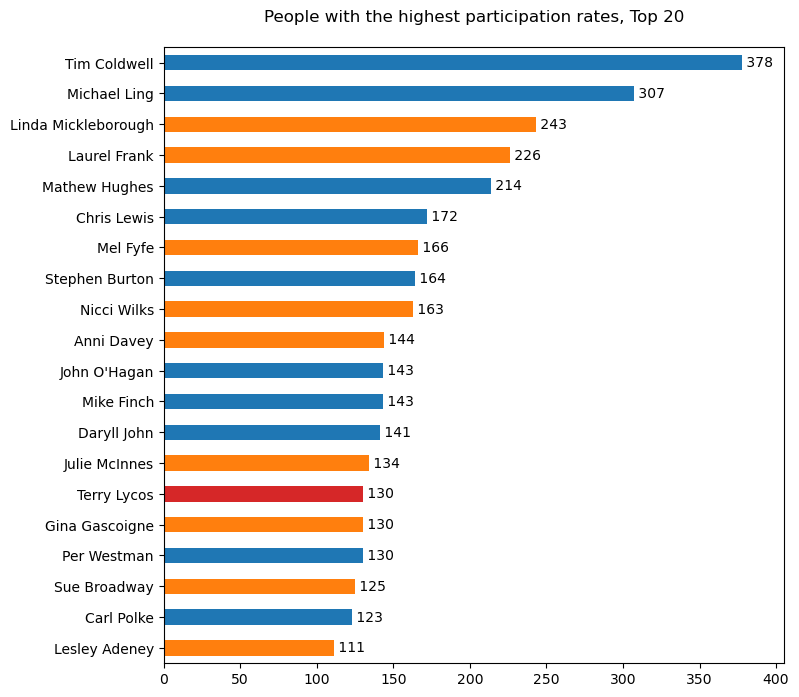

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

persons_freq = pd.DataFrame(df_noinjuries['COMBINED.NAME'].value_counts())

tab_df = persons_freq\
    .reset_index()\
    .rename({'index':'Person',
             'COMBINED.NAME':'Frequency'}, axis=1)\
    .head(20)\
    .sort_values('Frequency')

# labels = (tab_df['Frequency']/persons_freq.shape[0])\
#         .round(2).astype('str') + '%'

labels = ' ' + tab_df['Frequency'].astype('str')

tab_df.plot.barh(x='Person', y='Frequency',rot=0, ax=ax,
                  color=['tab:orange','tab:blue',
                         'tab:orange','tab:blue',
                         'tab:orange','tab:red',
                         'tab:orange','tab:blue',
                         'tab:blue','tab:blue',
                         'tab:orange','tab:orange',
                         'tab:blue','tab:orange',
                         'tab:blue','tab:blue',
                         'tab:orange','tab:orange',
                         'tab:blue','tab:blue'])

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('People with the highest participation rates, Top 20\n')

plt.xlim([0, 405])
plt.show()

```{epigraph}
99% of all events in the data have links to the top 1% of most active participants.
```

### Roles

We take a deep dive into the recorded roles across the participant data. A person can have many roles within an event.

We first review the distribution across role types by treating each role within an event for a given person as one record. `Performer` has the most records making up 37% of the data.

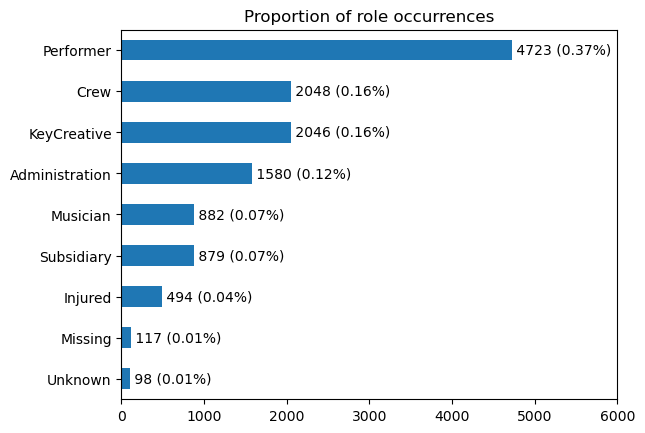

In [11]:
df['Role.Category.Concatinate'] = df['Role.Category.Concatinate'].fillna('Missing')

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in df['Role.Category.Concatinate'].values]
transactions_m = [row.split() for row in 
                  df[df.Gender=='M']['Role.Category.Concatinate'].values]
transactions_f = [row.split() for row in 
                  df[df.Gender=='F']['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles = role_count.sort_values('Count', ascending=True)

labels = ' ' + toproles['Count'].astype('str') + ' (' \
         + (toproles['Count']/toproles['Count'].sum())\
         .round(2).astype('str') + '%)'

ax = toproles.plot.barh(x='Role', y='Count',rot=0)

# add bar labels
[ax.bar_label(container, labels=labels) 
 for container in ax.containers]

# remove legend and y-axis title
ax.legend().set_visible(False)
plt.ylabel(None)
plt.title('Proportion of role occurrences')

plt.xlim([0, 6000])
plt.show()

#### How many roles on average?

We explore whether certain roles on average (median) tend to be pairs or not. The visualisaiton below highlights the median number of roles given a role type. This bar chart suggests that most of time people tend to do one role only during an event.

We also tested averaged differences for data filtered on `Males` and `Females`, and found only one difference. Our findings are summarised below.
- On average, female `Musician` tend to have one extra role, while majority of male musicians are solely `Musician`.
- 50% of female `Musician` are also listed as being a `Performer`.
- 15% of female `Musician` are also listed as being a `KeyCreative`.

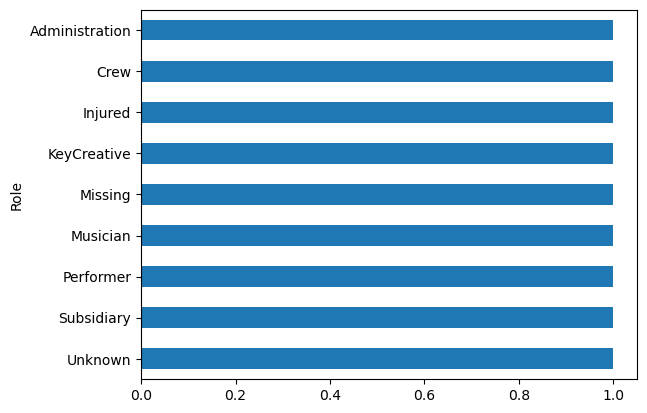

In [12]:
roles_unique = []

for ele in transactions:
    x=np.array(ele)
    roles_unique.extend(x)
    
roles_averages = dict()

for y in list(np.unique(np.array(roles_unique))):
    number_roles = []
    _ = [number_roles.append(len(x)) for x in transactions if y in x]
    roles_averages[y] = pd.DataFrame(number_roles).median().values[0]
    
roles_averages_df = pd.DataFrame(roles_averages.items())
roles_averages_df.columns = ['Role','Avg. no of Roles']
roles_averages_df = roles_averages_df.set_index('Role')
roles_averages_df.sort_values('Role', ascending=False).plot(kind = 'barh')

# adjust legend
plt.legend().set_visible(False)
plt.show()

# check for differences between Male and Female subsets
for y in list(np.unique(np.array(roles_unique))):
    number_roles_m = []
    number_roles_f = []
    _ = [number_roles_m.append(len(x)) for x in transactions_m if y in x]
    _ = [number_roles_f.append(len(x)) for x in transactions_f if y in x]
    diff = pd.DataFrame(number_roles_m).median().values[0] - pd.DataFrame(number_roles_f).median().values[0]
    # if abs(diff) >= 1: print(y, pd.DataFrame(number_roles_m).median().values[0],
    #                         pd.DataFrame(number_roles_f).median().values[0])

```{epigraph}
On average, female musicians tend to have one extra role, while majority of male musicians are solely a musician.
```

#### Association Rule Mining

Now we assess the occurrences of multiple roles happening together. We adopt association rule mining as it can help us answer questions such as what's the likelihood of a `Perfomer` also being a `Musician`. This becomes more interesting as we drill down across gender and time. 

We start by generating association rules for the data in its entirety.
- 69% of people who are KeyCreatives and Musicians tend to also be Performers
- 41% of people who are Musicians tend to also be Performers
- 26% of people who are KeyCreatives and Performers tend to also be Musicians

In [13]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, 
                             metric="lift", 
                             min_threshold=1)

# rules_ap[rules_ap.lift >= 1].sort_values('confidence', ascending = False).head(10)
rules_ap.sort_values('confidence', ascending = False)\
.drop(['lift','leverage','conviction'],axis=1) #.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence
3,"(KeyCreative, Musician)",(Performer),0.007494,0.393256,0.005162,0.688889
1,(Musician),(Performer),0.073439,0.393256,0.030475,0.414966
2,"(KeyCreative, Performer)",(Musician),0.019567,0.073439,0.005162,0.263830
0,(Performer),(Musician),0.393256,0.073439,0.030475,0.077493
5,(Musician),"(KeyCreative, Performer)",0.073439,0.019567,0.005162,0.070295
4,(Performer),"(KeyCreative, Musician)",0.393256,0.007494,0.005162,0.013127


```{note}
- **Antecedents**: Antecedents are the items or conditions that are present in a given itemset (i.e., roles) in an association rule. They are also known as the "left-hand side" or "premise" of the rule.
- **Consequents**: Consequents are the items or conditions that are predicted to occur in a given itemset based on the presence of the antecedents in the association rule. They are also known as the "right-hand side" or "conclusion" of the rule.
- **Antecedent support**: Antecedent support is the percentage of itemsets in the dataset that contain the antecedents of an association rule.
- **Consequent support**: Consequent support is the percentage of itemsets in the dataset that contain the consequents of an association rule.
- **Support**: Support is a measure of how frequently an association rule occurs in the dataset. It is calculated as the percentage of itemsets that contain both the antecedents and the consequents of the rule.
- **Confidence**: Confidence is a measure of how strongly the presence of the antecedents in an itemset predicts the presence of the consequents. It is calculated as the percentage of itemsets that contain the antecedents and the consequents, divided by the percentage of itemsets that contain the antecedents.
```

Next we generate association rules for `Male` data and `Female` data, and compare the confidence of the rules to highlight any significant differences. Below are rules with a difference larger than 5%.

- `Males` who are `KeyCreatives` tend to also be `Performers` 6\% more than `Females`
- `Females` who are `Musicians` tend to also be `Performers` 5\% more than `Males`.

In [14]:
te = TransactionEncoder()
te_array = te.fit(transactions_m).transform(transactions_m)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_m = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)

te = TransactionEncoder()
te_array = te.fit(transactions_f).transform(transactions_f)
te_df = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(te_df, min_support=0.005, use_colnames=True)
rules_ap_f = association_rules(frequent_itemsets_ap, 
                             metric="confidence", 
                             min_threshold=0.005)


pd.set_option('display.float_format', lambda x: '%.3f' % x)

supports = pd.merge(rules_ap_m, rules_ap_f, on=['antecedents','consequents'])
supports = supports[['antecedents','consequents',
                      'support_x','support_y',
                      'confidence_x','confidence_y']]
supports.columns = ['antecedents','consequents', 'support_M','support_F',
                      'confidence_M','confidence_F']         
supports['diff'] = supports['confidence_M'] - supports['confidence_F']
supports[abs(supports['diff']) > 0.05].sort_values('diff', ascending=False)

,antecedents,consequents,support_M,support_F,confidence_M,confidence_F,diff
2,(KeyCreative),(Performer),0.031,0.019,0.149,0.091,0.057
5,(Musician),(Performer),0.046,0.027,0.445,0.498,-0.053


#### Role changes over time

We visualise role types over time excluding Missing, Unknown and Injured categories. Across each five-year period, `Performer` is the role type with the highest frequency, followed by `KeyCreative` and `Crew`. All role types follow a similiar trajectory, with the exception of `Musician`.

The second visulisation uses proportion instead of frequency - this allows for a more balanced view for each respective five-year period. It tells a slightly different story in which the `Performer` role is proportionally decreasing.

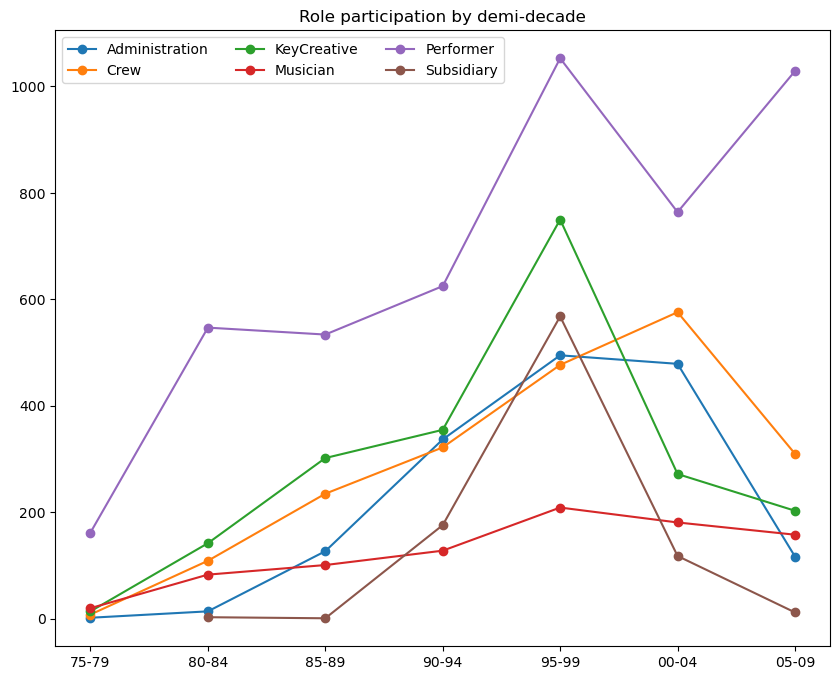

In [15]:
# remove injuries and missing data
df_noinjuries = df[df['Role.Category.Concatinate'] != 'Injured']

df_noinjuries["Role.Category.Concatinate"] = df_noinjuries["Role.Category.Concatinate"]\
    .apply(lambda x: re.sub("Injured", "", x))\
    .apply(lambda x: re.sub("Unknown", "", x))\
    .str\
    .strip()
    
df_noinjuries = df_noinjuries[~df_noinjuries["Role.Category.Concatinate"].isin(["", "Missing", "Unknown"])]

toproles_decade = pd.DataFrame()

### 1975
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 1975]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1975
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1980
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 1980]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1980
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()

toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1985
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 1985]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1985
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1990
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 1990]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1990
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 1995
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 1995]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 1995
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 2000
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 2000]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2000
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

### 2005
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 2005]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2005
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])


### 2010
data_70s = df_noinjuries[df_noinjuries['Year_decade'] == 2010]

# convert the DataFrame to a list of transactions
transactions = [row.split() for row in data_70s['Role.Category.Concatinate'].values]

roles_dict = dict()

#printing the counts
for role in transactions:
    for r in role:
        if r in roles_dict: roles_dict[r] += 1
        else: roles_dict[r] = 1
            
role_count = pd.DataFrame(roles_dict.items(), 
                          columns=['Role', 'Count'])
toproles_70s = role_count.sort_values('Count', ascending=True)
toproles_70s['Decade'] = 2005
toproles_70s['Proportion'] = toproles_70s['Count']/toproles_70s['Count'].sum()
toproles_decade = pd.concat([toproles_decade,toproles_70s])

fig, ax = plt.subplots(figsize=(10, 8))

for x in toproles_decade['Role'].unique():
    plt.plot(toproles_decade[toproles_decade['Role']== x]['Decade'],
             toproles_decade[toproles_decade['Role']== x]['Count'], 
             label = x, marker='o')

plt.legend(loc="upper left", ncol=3)
plt.title('Role participation by demi-decade', )
ax.set_xlabel('')

plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

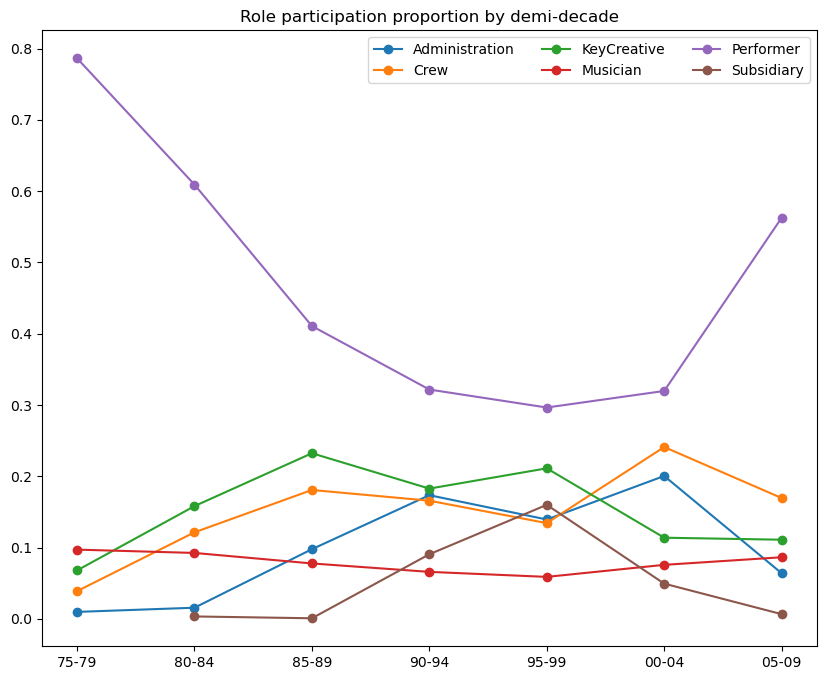

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

for x in toproles_decade['Role'].unique():
    plt.plot(toproles_decade[toproles_decade['Role']== x]['Decade'],
             toproles_decade[toproles_decade['Role']== x]['Proportion'], 
             label = x, marker='o')

plt.legend(loc="upper right", ncol=3)
plt.title('Role participation proportion by demi-decade', )
ax.set_xlabel('')
plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'])
plt.show()

#### Male and female proportion by role over time

We isolate the data for each role and assess the data with respect to `Males` and `Females`. This is repeated using proportions. Main findings are listed below.

- There have been more female `KeyCreatives` over time, with the exception of 95-99 and 05-09.
- Post-1995 more males have worked as `Crew` members.
- There have been more male `Musicians` over time, with the exception of 85-89 and 05-09.
- There have been more male `Performers` over time.
- There have been more females working in `Administration` over time. Interesting to see no `Administration` records prior to 1980.
- There have been more females working as a `Subsidiary`, however data is only recorded between 1990 and 2004.
<br><br>
- In 00-04 period, there appears to be very little proportion of Female Musicians.


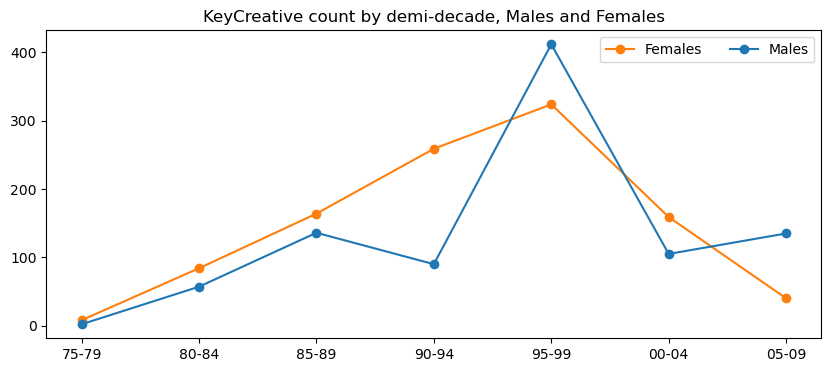

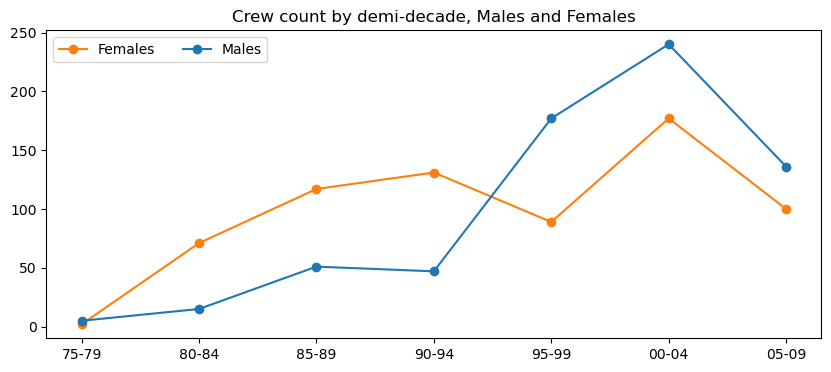

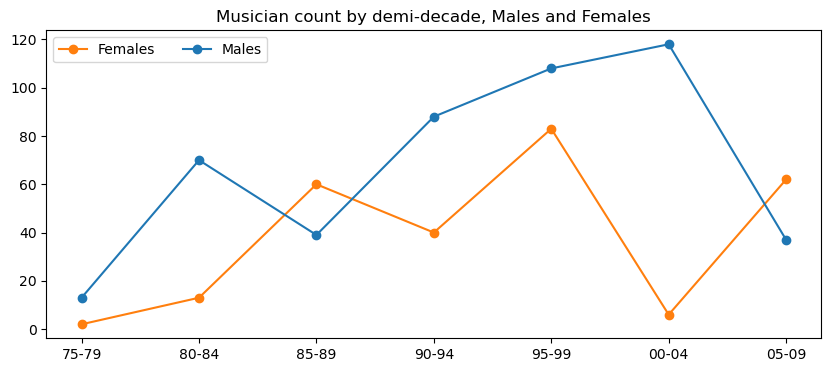

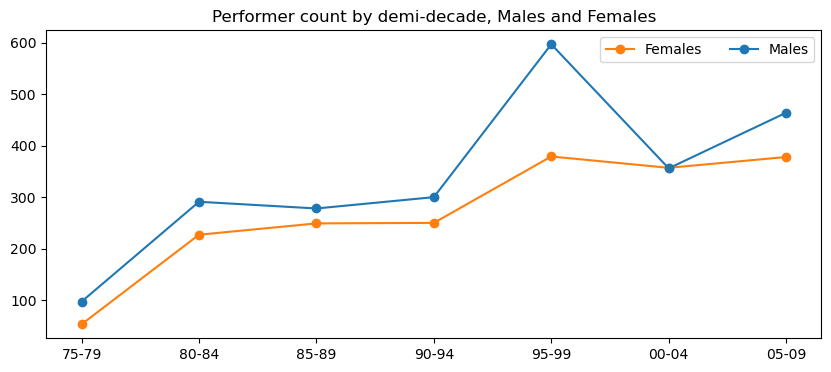

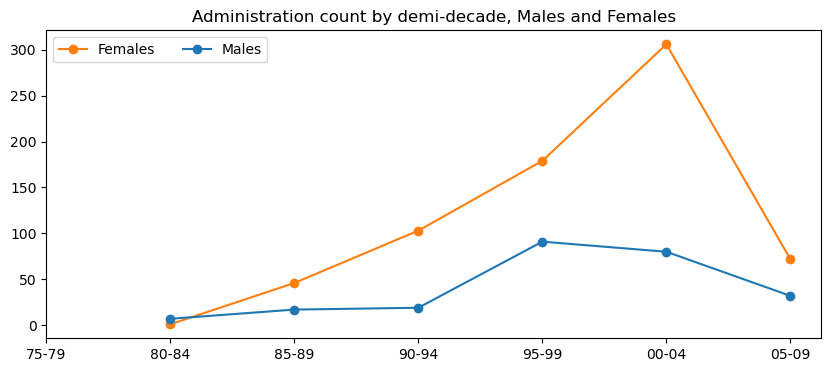

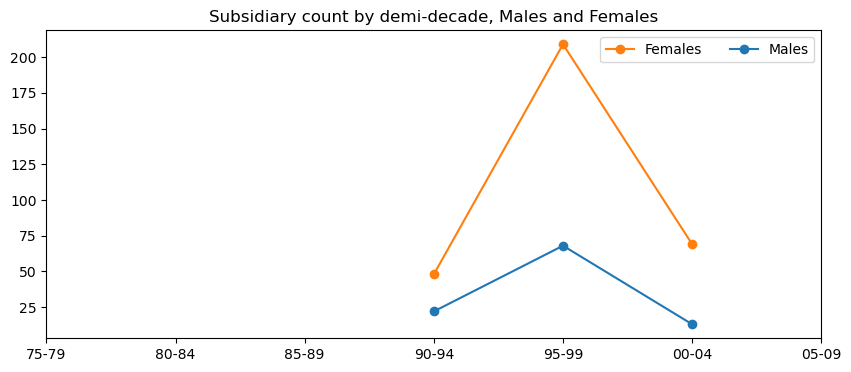

In [17]:
toproles_decade_gender = pd.DataFrame()
supports_decade = pd.DataFrame()

for x in list(df_noinjuries['Year_decade'].unique())[:-1]: 
    ### 1975
    data_70s = df_noinjuries[df_noinjuries['Year_decade'] == x]

    # convert the DataFrame to a list of transactions
    transactions_m = [row.split() for row in 
                      data_70s[(data_70s.Gender=='M')]['Role.Category.Concatinate'].values]
    transactions_f = [row.split() for row in 
                      data_70s[data_70s.Gender=='F']['Role.Category.Concatinate'].values]
    roles_dict = dict()

    #printing the counts
    for role in transactions_m:
        for r in role:
            if r in roles_dict: roles_dict[r] += 1
            else: roles_dict[r] = 1

    role_count = pd.DataFrame(roles_dict.items(), 
                              columns=['Role', 'Count'])
    toproles_70s_m = role_count.sort_values('Count', ascending=True)
    toproles_70s_m['Decade'] = x
    # toproles_70s_m['Gender'] = 'Male'

    roles_dict = dict()
    
    #printing the counts
    for role in transactions_f:
        for r in role:
            if r in roles_dict: roles_dict[r] += 1
            else: roles_dict[r] = 1

    role_count = pd.DataFrame(roles_dict.items(), 
                              columns=['Role', 'Count'])
    toproles_70s_f = role_count.sort_values('Count', ascending=True)
    toproles_70s_f['Decade'] = x
    # toproles_70s_f['Gender'] = 'Female'
    
    toproles_70s_mf = pd.merge(toproles_70s_m, toproles_70s_f[['Role','Decade','Count']], on=['Role','Decade'])
    toproles_70s_mf['count_sum'] = toproles_70s_mf['Count_x'] + toproles_70s_mf['Count_y']
    toproles_70s_mf['Proportion_x'] = toproles_70s_mf['Count_x']/toproles_70s_mf['count_sum']
    toproles_70s_mf['Proportion_y'] = toproles_70s_mf['Count_y']/toproles_70s_mf['count_sum']
    toproles_decade_gender = pd.concat([toproles_decade_gender,toproles_70s_mf])
    
    te = TransactionEncoder()
    te_array = te.fit(transactions_m).transform(transactions_m)
    te_df = pd.DataFrame(te_array, columns=te.columns_)
    frequent_itemsets_ap = apriori(te_df, min_support=0.001, use_colnames=True)
    rules_ap_m = association_rules(frequent_itemsets_ap, 
                                 metric="confidence", 
                                 min_threshold=0.001)

    te = TransactionEncoder()
    te_array = te.fit(transactions_f).transform(transactions_f)
    te_df = pd.DataFrame(te_array, columns=te.columns_)
    frequent_itemsets_ap = apriori(te_df, min_support=0.001, use_colnames=True)
    rules_ap_f = association_rules(frequent_itemsets_ap, 
                                 metric="confidence", 
                                 min_threshold=0.001)

    supports = pd.merge(rules_ap_m, rules_ap_f, on=['antecedents','consequents'])
    supports['Decade'] = x
    supports_decade = supports_decade.append(supports)

toproles_decade_gender.columns = ['Role','Count_m','Decade','Count_f',
                                  'count_sum','Proportion_m','Proportion_f']

for x in toproles_decade_gender['Role'].unique():
    fig, ax = plt.subplots(figsize=(10, 4))

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Count_f'], 
             label = 'Females', marker='o', color='tab:orange')

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Count_m'], 
             label = 'Males', marker='o',  color='tab:blue')

    plt.legend(loc="best", ncol=3)
    plt.title(f'{x} count by demi-decade, Males and Females', )
    ax.set_xlabel('')

    plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                                '95-99', '00-04','05-09'])
    plt.show()

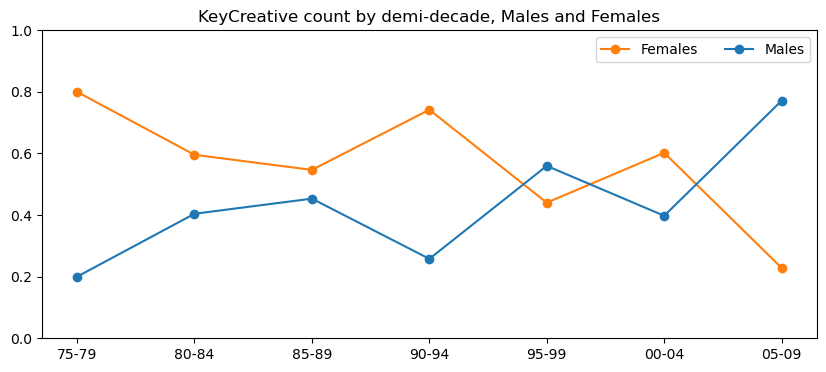

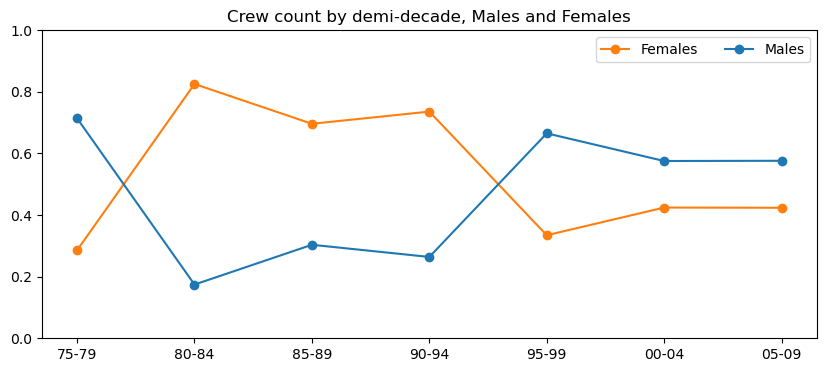

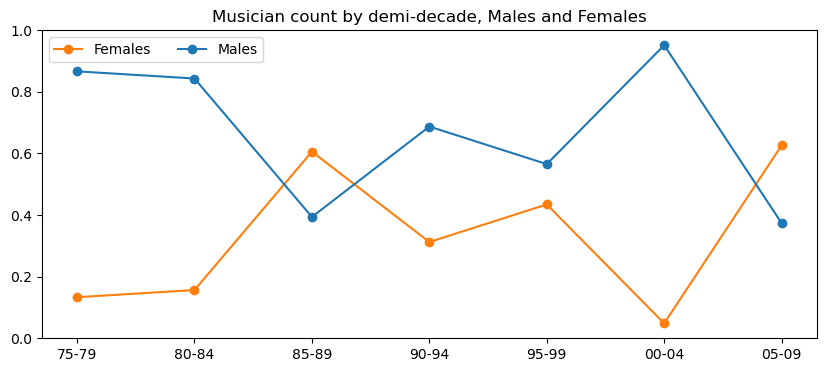

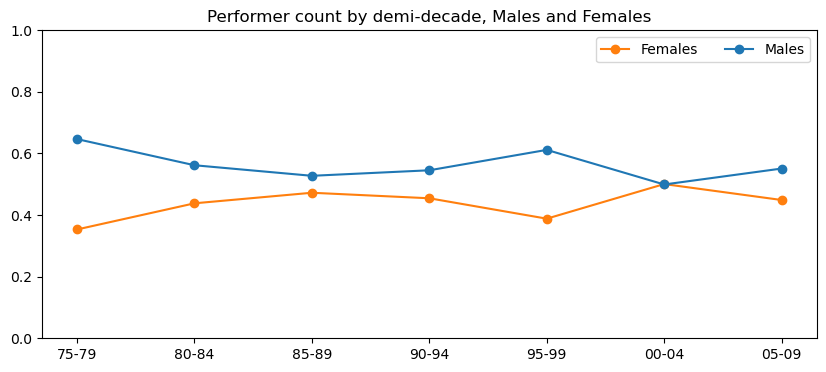

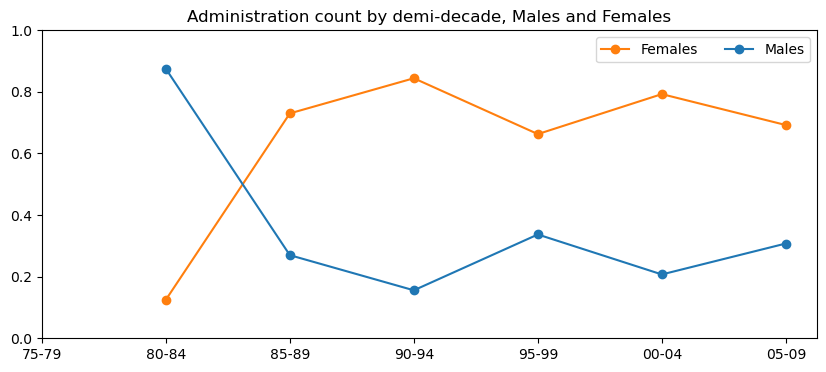

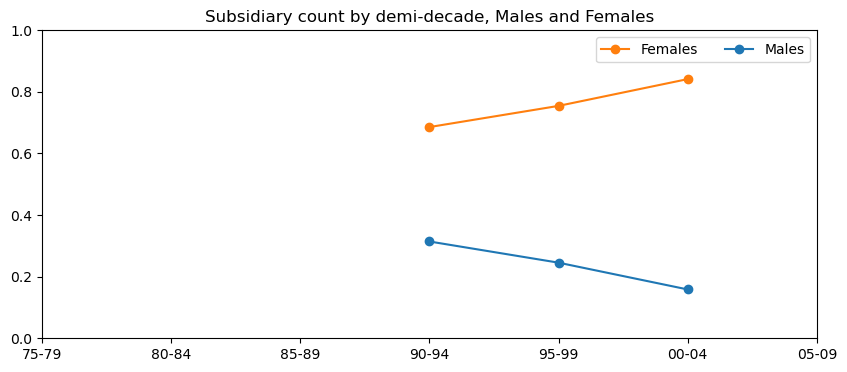

In [18]:
for x in toproles_decade_gender['Role'].unique():
    fig, ax = plt.subplots(figsize=(10, 4))

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Proportion_f'], 
             label = 'Females', marker='o', color='tab:orange')

    plt.plot(toproles_decade_gender[toproles_decade_gender['Role']==x]['Decade'],
             toproles_decade_gender[toproles_decade_gender['Role']==x]['Proportion_m'], 
             label = 'Males', marker='o',  color='tab:blue')

    plt.legend(loc="best", ncol=3)
    plt.title(f'{x} count by demi-decade, Males and Females', )
    ax.set_xlabel('')

    plt.ylim([0, 1])
    plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                                '95-99', '00-04','05-09'])
    plt.show()

#### Association Rule Mining (cont.)

We now review association rules across time and gender. For each generated rule, we calculated the difference of the **confidence** of said rule for `Males` with the **confidence** of the same rule for `Females` for each given five-year period. 

Positive differences indicate that the rule occurs more often for `Males` while negative differences indicate that the rule occurs more often for `Females`. We then sorted the differences by its absolute value and inspected the most significant rules visually (see coloured time series plot).

The table below highlights association rule differences of more than 20%. We provide some examples of how one might interpret these rule differences highlighted in the column `Male-Female difference`.
<br>
- Example (1): `Females` who are `Musicians` (see antecedents) are 35.9% more likely than `Males` to also be a `Performer` (see consequents) in 85-89 period.
- Example (2): `Females` who are `Musicians` are 28.2% more likely than `Males` to also be a `KeyCreative` in 85-89 period.
- Example (3): `Males` who are `Subsidiaries` are 27.9% more likely than `Females` to also be a `Performer` in 00-04 period.

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

supports = supports_decade[['antecedents','consequents',
                      'support_x','support_y',
                      'confidence_x','confidence_y','Decade']]
supports['Male-Female difference'] = (supports['confidence_x'] - supports['confidence_y'])*100
supports['diff_abs'] = abs(supports['Male-Female difference'])
supports_shrt = supports[supports['diff_abs'] > 20].sort_values('diff_abs', ascending=False)
supports_shrt[['antecedents','consequents','Decade','Male-Female difference']]

,antecedents,consequents,Decade,Male-Female difference
9,(Musician),(Performer),1985,-35.897
5,(Musician),(KeyCreative),1985,-28.205
9,(Subsidiary),(Performer),2000,27.871
1,(Musician),(Performer),1975,26.923
2,(KeyCreative),(Performer),1995,23.921


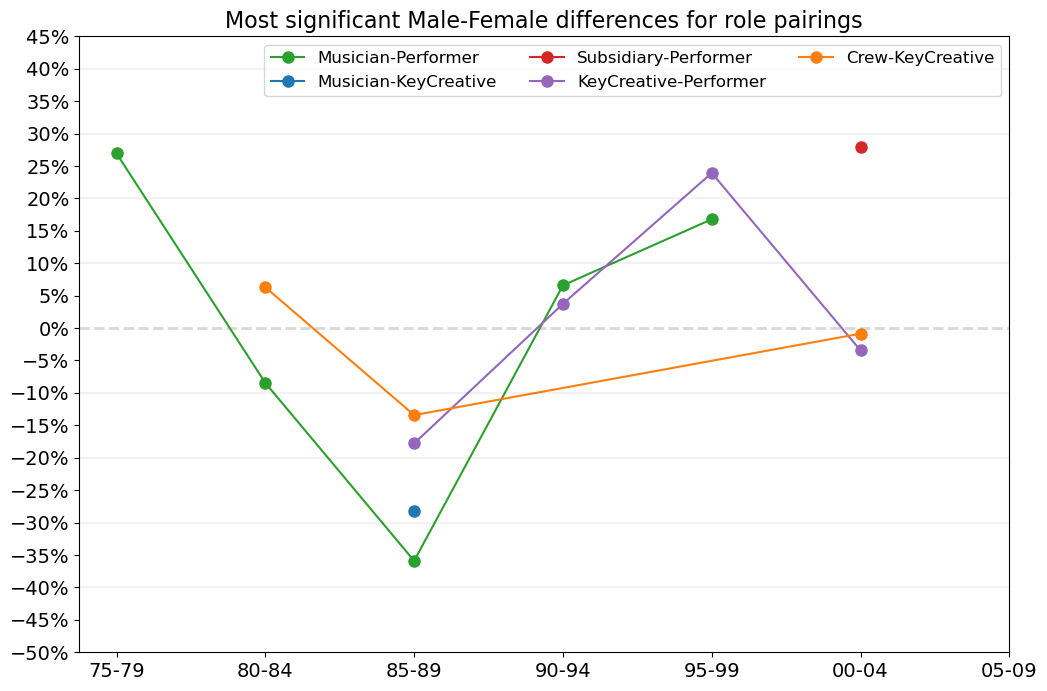

In [20]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 8))

this_pair = supports[(supports.antecedents == frozenset({'Musician'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['Male-Female difference'], marker='o', 
         color='tab:green', label='Musician-Performer', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Musician'})) & 
             (supports.consequents == frozenset({'KeyCreative'}))]
plt.plot(this_pair['Decade'], this_pair['Male-Female difference'], marker='o', 
         color='tab:blue', label='Musician-KeyCreative', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Subsidiary'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['Male-Female difference'], marker='o', 
         color='tab:red', label='Subsidiary-Performer', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'KeyCreative'})) & 
             (supports.consequents == frozenset({'Performer'}))]
plt.plot(this_pair['Decade'], this_pair['Male-Female difference'], marker='o', 
         color='tab:purple', label='KeyCreative-Performer', markersize=8)

this_pair = supports[(supports.antecedents == frozenset({'Crew'})) & 
             (supports.consequents == frozenset({'KeyCreative'}))]
plt.plot(this_pair['Decade'], this_pair['Male-Female difference'], marker='o', 
         color='tab:orange', label='Crew-KeyCreative', markersize=8)

plt.title('Most significant Male-Female differences for role pairings',
         fontsize=16)

plt.axhline(y=0, linestyle='--', color='grey', alpha=0.3, lw=2)
plt.axhline(y=-10, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=-20, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=-30, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=-40, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=10, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=20, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=30, linestyle='-', color='black', alpha=0.05)
plt.axhline(y=40, linestyle='-', color='black', alpha=0.05)


# adjust legend
ax.legend(loc="upper right", ncol=3, fontsize=12)

plt.yticks(range(-50, 50, 5), range(-50, 50, 5), fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(1975, 2010, 5), ['75-79', '80-84','85-89', '90-94',
                            '95-99', '00-04','05-09'], fontsize=14)

plt.show()

### Network graphs

Lastly, we developed an interactive tool to assist in drilling down into influential people and roles across any given period of time.

**Instructions**
1. Choose years to establish the start and end period. These values are inclusive. We also provide the option to include roles listed as `Injured`.
2. Press the `Generate network graph` button, this will load a network graph along with the top 3 association rules for the selected time period. _Note that the network graph will take longer to load if the time period is large i.e., can take up 90 seconds to load for all data._
3. You can zoom in/out, drag nodes, highlight node neighbours by clicking, hover over nodes for more info and highlight nodes using the filter on the top left. The filter lists all the roles first and then lists each relevant node in order of its participation rate for the given period.
4. If you want to make any changes to the time period (or include `Injured`), you will need to press the `Generate network graph` button again to generate a new network graph along with corresponding association rules.

**Legend**
- Blue nodes represent `Male` participants.
- Orange nodes represent `Female` participants.
- Red nodes represent `0` participants.
- Green nodes represent roles i.e., `Musician`, `Performer`, etc.
- Edges represent an occurence in the given time period - they are uniformally weighted.
- The size of a participant node corresponds with the number of participated events in the given time period. This frequency can be obtained by hovering over the node.

_It should be noted that association rules are only generated if rules are relatively significant - in cases where there are no rules, the output will flag an error._

<iframe height="1100" width="800" frameborder="no" src="https://acd-engine.shinyapps.io/CircusOzApp/"> </iframe>